# Homework 4 - Miles Benjamin - CS 6140

In [1]:
import numpy as np
import math
import random
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as scio
import pprint as pp
import skimage as ski
import skimage.transform as skit

%matplotlib inline 

## 1. Feed Forward Neural Network

In [2]:
mat = scio.loadmat('./ExtYaleB10.mat')
#pp.pprint(mat)
Y_test = mat['test']
Y_train = mat['train']
#print(Y_train[0])
print('shape of the data is [%d]' % Y_train[0].shape)
print('shape of the data is [%d, %d, %d]' % Y_train[0][0].shape)
Y = np.mat(Y_train).T
print('shape of the data is [%d, %d]' % Y.shape)

shape of the data is [10]
shape of the data is [192, 168, 50]
shape of the data is [10, 1]


In [3]:
# input the array of 50 images
def downsampleImage(imgs):
    img = []
    temp = []
    for i in range(len(imgs[0][0])):
            img = imgs[:][:][i]
            img = skit.resize(img,[20,17],mode='constant').flatten()
            temp.append(img)
            
    #print(np.array(temp).shape)
    return temp

In [4]:
imgs = downsampleImage(Y_train[0][0])

In [5]:
def rec(x):
    if (x < 0):
        x = 0
    return x    
def sig(x):
    x = np.exp(x)
    x += 1
    x = 1/x
    return x
    
def ht(x):
    temp = np.exp(x) - np.exp(-x)
    temp = temp /(np.exp(x) + np.exp(-x))
    return temp

def activationFunc(X, activ):
    if (activ == 'rec'):
        for i in range(len(X)):
            X[i] = rec(X[i])
            return X
    elif (activ == 'sig'):
        for i in range(len(X)):
            X[i] = sig(X[i])
            return X
    elif (activ == 'ht'):
        for i in range(len(X)):
            X[i] = ht(X[i])
            return X

In [6]:
def recD(x):
    if (x <= 0):
        return 0
    return 1
def sigD(x):
    y = sig(x) * (1- sig(x))
    return y
    
def htD(x):
    temp = 1- np.tanh(x)**2
    return temp

def activationFuncD(X, activ):
    if (activ == 'rec'):
        for i in range(len(X)):
            X[i] = recD(X[i])
            return X
    elif (activ == 'sig'):
        for i in range(len(X)):
            X[i] = sigD(X[i])
            return X
    elif (activ == 'ht'):
        for i in range(len(X)):
            X[i] = htD(X[i])
            return X

In [7]:
temp = ['rec', 'sig', 'ht']
temp2 = [[5], [-5]]

temp3 = []
for i in range(len(temp)):
    for j in range(len(temp2)):
        temp3.append(activationFunc(temp2[j], temp[i]))

print(temp3)    

[[0.0066927509923217993], [0.46211715726000979], [0.0066927509923217993], [0.46211715726000979], [0.0066927509923217993], [0.46211715726000979]]


In [8]:
# W's shape is as follows: W[l][s(l+1)][s(l)]

def FFNN_Initialize(data, s1, s2, s3):
    X = [0] * s1
    X = np.mat(X)
    Y = []
    temp = 0
    tempx = []
    cat = len(data[0])
    for i in range(len(data[0])):
        tempx = downsampleImage(data[0][i])
        tempx = np.mat(tempx)   
        X = np.vstack((X,tempx))
        temp = [i/cat] * len(tempx)
        Y.append(temp)
    
    X = X[1:][:]
    Y = np.array(Y).flatten()
    
    B = []
    S = [s1,s2,s3,1]
    W = [0] * 3
    for i in range(len(W)):
        W[i] = [0] * S[i+1]
        for j in range(len(W[i])):
            W[i][j] = [np.random.rand() * 0.0001] * S[i]
       
    for i in range(len(S) -2):
        B.append(np.random.rand() * 0.0001)
    
    return X,Y,W,B,S

In [9]:
def FFNN_FeedForward(xi,yi,W,B,S, activ):
    L = (len(S) -1)
    Z = [0] * L
    A = [0] * L
    
    Z[0] = xi
    A[0] = xi
    lastA = xi
    for i in range(L - 1):
        temp = [0]*S[i+1]
  
        for j in range(S[i+1]):
            temp[j] = np.mat(lastA) * np.mat(W[i][j]).T
            temp[j] += B[i]
            temp[j] = temp[j].A1.tolist()
        
        temp = np.mat(temp).T.A
        
        Z[i+1] = temp[0]
        A[i+1] = activationFunc(temp[0], activ)
       # if (i +1 == 2):
           # print(temp, A[i +1], yi)
        lastA = A[i+1]
    
    
    return Z,A

In [10]:
def FFNN_BackProp(Z,A,yi,W,B,S, activ, ro):
    L = len(S) -1
    Delta = [0] * L
    
    Delta[L-1] = np.multiply((A[L-1] - yi),activationFuncD(np.mat(Z[L-1]).T.A, activ))
   # print(Delta[L-1])
    for i in range(L -2, -1, -1):
        # print(np.array(Z[i]).shape)
        Delta[i] = np.multiply(np.mat(W[i]).T * np.mat(Delta[i+1]),activationFuncD(np.mat(Z[i]).T.A, activ))
    
    #print(Delta)
    for i in range(L -1):
        W[i] = W[i] - ro * (Delta[i+1] * np.mat(A[i]))
        B[i] = B[i] - ro * np.sum(Delta[i +1])
    
    return W,B

In [11]:
# activ takes the following values: sig, ht, rec
def FFNN_Train(data, s1, s2, s3, activ, ro):
    X,Y,W,B,S = FFNN_Initialize(data, s1, s2, s3)

    
    for i in range(len(X)):
        Z,A = FFNN_FeedForward(X[i],Y[i],W,B,S, activ)
        W,B = FFNN_BackProp(Z,A,Y[i],W,B,S, activ, ro)
    
    print("training complete")
    return W,B

In [12]:
def FFNN_Test(data, s1, s2, s3, activ, W,B):
    X,Y,temp,temp2,S = FFNN_Initialize(data,s1,s2,s3)

    error = 0
    print("testing to begin")
    for i in range(len(X)):
        Z,A = FFNN_FeedForward(X[i],Y[i],W,B,S,activ)
        error += np.abs(Y[i] - A[2])
        #print('Z: ', Z[2],' A :', A[2], ' Y: ', Y[i])
      
    
    return error

## 2. Auto Encoder

In [13]:
# W's shape is as follows: W[l][s(l+1)][s(l)]

def Auto_Initialize(data, s1, s2, s3):
    X = [0] * s1
    X = np.mat(X)
    Y = []
    temp = 0
    tempx = []
    cat = len(data[0])
    for i in range(len(data[0])):
        tempx = downsampleImage(data[0][i])
        tempx = np.mat(tempx)   
        X = np.vstack((X,tempx))

    
    X = X[1:][:]
    Y = X
    
    B = []
    S = [s1,s2,s3,1]
    W = [0] * 3
    for i in range(len(W)):
        W[i] = [0] * S[i+1]
        for j in range(len(W[i])):
            W[i][j] = [np.random.rand() * 0.0001] * S[i]
       
    for i in range(len(S) -2):
        B.append(np.random.rand() * 0.0001)
    
    return X,Y,W,B,S

In [14]:
# activ takes the following values: sig, ht, rec
def Auto_Encode(data, s1, s2, s3, activ, ro):
    X,Y,W,B,S = Auto_Initialize(data, s1, s2, s3)

    
    for i in range(len(X)):
        Z,A = FFNN_FeedForward(X[i],Y[i],W,B,S, activ)
        W,B = FFNN_BackProp(Z,A,Y[i],W,B,S, activ, ro)
    
    print("training complete")
    return W,B

In [15]:
#W,B = Auto_Encode(Y_train, 340, 3, 340, 'ht', 0.001)

## 3. Testing Algorithms on Data

### 3.a. Testing NN

In [16]:
# 1.

# I'm pretty sure there's a bug in my code that's causing my NN to underperform.  
# However I'm up against the time deadline and I need to keep going.

# used to determine my best parameters takes forever to run, I don't recommend it

"""

ros = [1e-05,1e-06, 1e-07]
s2s = [3,4,5,6,7]
func = ['rec','sig','ht']
bestRun = [0,0,0,1000000]

for i in range(len(ros)):
    for j in range(len(s2s)):
        for k in range(len(func)):
            print("ro: ", ros[i], " s2: ", s2s[j], " func: ", func[k])
            W,B = FFNN_Train(Y_train, 340, s2s[j], 1, func[k], ros[i])
            error = FFNN_Test(Y_test, 340, s2s[j], 1, func[k], W,B)
            print("error: ", error)
            if (error < bestRun[3]):
                bestRun[0] = ros[i]
                bestRun[1] = s2s[j]
                bestRun[2] = func[k]
                bestRun[3] = error

print("Best Run:", bestRun)

"""

#Best Run: [1e-05, 3, 'sig', array([ 35.00000065])]
W,B = FFNN_Train(Y_train, 340, 3, 1, 'sig', 1e-05)
error = FFNN_Test(Y_test, 340, 3, 1, 'sig', W,B)
print(error)

training complete
testing to begin
[ 35.00000535]


### 3.b. 1 v all SVM

In [17]:
def Data_Flattener(data,s):
    X = [0] * s
    X = np.mat(X)
    Y = []
    temp = 0
    tempx = []
    cat = len(data[0])
    for i in range(len(data[0])):
        tempx = downsampleImage(data[0][i])
        tempx = np.mat(tempx)   
        #print(tempx.shape)
        X = np.vstack((X,tempx))
        temp = [i] * len(tempx)
        Y.append(temp)
    
    X = X[1:][:]
    Y = np.array(Y).flatten()
    
    return X,Y

In [18]:


def kernelGen(X):
    K = []
    for i in range(len(X)):
        temp = []
        for j in range(len(X)):
            xi = np.mat(X[i])
            xj = np.mat(X[j])
            
            temp.append(np.dot(xi,xj.T).A)
        K.append(np.concatenate(temp).ravel().tolist())

    return K
def dualF(Y,K,j,b,alpha):
    E = 0
    for i in range(len(K)):
        innx = K[i][j]
        
        E += (alpha[i] * Y[i] * innx)
        
    E = E + b - Y[j]
    
    
    return E
def simplifiedSMO(K,Y,c,tol,maxPass):
    alpha = np.zeros((len(K)))
    b = 0
    passes = 0
    while(passes < maxPass):
        num_changed_alphas = 0
        for i in range(len(K)):
            Ei = dualF(Y, K, i, b, alpha)
            temp = Ei * Y[i]
            
            if (((temp < (-1 * tol)) and (alpha[i] < c)) or ((temp > tol) and (alpha[i] > 0))):
                j = random.randint(0, len(K) -1)
                while (j == i):
                    j = random.randint(0, len(K) -1)
                    
                Ej = dualF(Y, K, j, b, alpha)
                # Save off old Alphas
                alOldi = alpha[i]
                alOldj = alpha[j]
                
                # Calculate L and H
                L = max(0, alpha[j] - alpha[i])
                H = min(c, c + alpha[j] - alpha[i])
                #print(str(L) + " " + str(H))
                
                if (L == H):
                    continue
                #calculate n (eta)
                
                n = (2* K[i][j]) - (K[i][i]) - (K[j][j])
                if (type(n) == 'float'):
                    if (n >= 0):
                        continue
                
                #calculate new aj
                alNewj = alOldj - ((Y[j] * (Ei - Ej))/n)
                alNewj = np.clip(alNewj, 0, c)
                
                
                if (alNewj > H):
                    alNewj = H
                elif (alNewj < L):
                    alNewj = L
                
                if (abs(alNewj - alOldj) < 10**(-5)):
                    continue
                
                alNewi = alOldi + (Y[i] * Y[j] * (alOldj - alNewj))
                alNewi = np.clip(alNewi, 0, c)
                
                alpha[i] = alNewi
                alpha[j] = alNewj
                
                # calculate bs
                b1 = b - Ei - (Y[i] * (alpha[i] - alOldi) * K[i][i]) - (Y[j] * (alpha[j] - alOldj) * K[i][j])
                b2 = b - Ej - (Y[i] * (alpha[i] - alOldi) * K[i][j]) - (Y[j] * (alpha[j] - alOldj) * K[j][j])
                
                b = (b1 + b2)/2
                
                if ((0 < alpha[i]) and (alpha[i] < c)):
                    b = b1
                elif ((0 < alpha[j]) and (alpha[i] < c)):
                    b = b2
                
                num_changed_alphas += 1
                
                #w = CostW(K,Y,alpha)
                #print(w)
            #end if
        #end for
        if (num_changed_alphas == 0):
            passes += 1
        else:
            passes = 0
            
    return [alpha, b]
def errorFSVM(Y, Ycomp):
    error = 0
    for i in range(len(Y)):
        if(Y[i] != Ycomp[i]):
            error += 1

    error = error / len(Y)  
    return error
def YPrep(Y, i):
    Y_temp = [0] * len(Y)
    for j in range(len(Y)):
        if (Y[j] != i):
            Y_temp[j] = -1
        else:
            Y_temp[j] = 1
    return Y_temp  

def SVMForAll(data, cat):
    #30336
    c = 0.5
    tol = 10**(-5)
    max_pass = 50
    X, Y = Data_Flattener(data, 340)
    X = np.mat(X)
    K = kernelGen(X)
    
    F = [0] * cat
    for i in range(cat):
        Y_temp = YPrep(Y,i)
        F[i] = simplifiedSMO(K,Y_temp,c, tol, max_pass)
        print("Class:", i, "vs all")
        SVMPost(F[i], X, Y_temp)
        
    return F    

def SVMPost(F, X, Y_temp):
    alpha = F[0]
    b = F[1]

    Wstar = 0
    for i in range(len(X)):
        Wstar += alpha[i]*Y_temp[i]*X[i]
    
    w = np.mat(Wstar)
    X = np.mat(X).T

    bias = np.mean(Y_temp - (w * X))

    Y = np.sign((w * X) + bias)

    #plt.plot(X.T, Y.T, 'o')
    #plt.plot(X.T, Y_trn, '.')
    error = errorFSVM(Y.T, Y_temp)

    print("training error: ", error * 100, "%")


In [19]:
# This one takes a while to run.  Might want to make some Tea.
F = SVMForAll(Y_test, 10)


Class: 0 vs all
training error:  44.285714285714285 %
Class: 1 vs all
training error:  36.42857142857142 %
Class: 2 vs all
training error:  40.714285714285715 %
Class: 3 vs all
training error:  35.714285714285715 %
Class: 4 vs all
training error:  32.142857142857146 %
Class: 5 vs all
training error:  45.0 %
Class: 6 vs all
training error:  42.857142857142854 %
Class: 7 vs all
training error:  35.714285714285715 %
Class: 8 vs all
training error:  41.42857142857143 %
Class: 9 vs all
training error:  41.42857142857143 %


### 3.c. 1 v all LogRegression

In [19]:


def H(x, w):
    h =  x * w
    h = 1 + np.exp(h)
    h = 1/h
    h = h.flatten()
    return h[0][0]

def gradientDescent(X, Y, w, alpha, ittr, batch):
   # print(X, Y, w, alpha)
    m = len(Y)
    
    for i in range(ittr):
        batchIdx = math.floor((sp.rand(1) * m))
        miniX = X[batchIdx]
        miniY = Y[batchIdx]
    
        miniX = np.mat(miniX)
        miniY = np.mat(miniY)
        
        temp = (miniY.T - H(miniX,w))
        temp = temp * miniX
        temp = temp * alpha
        
        # - 2 lambda w?
        
        w = w - temp.T
        #print(H(miniX,w))
    
    return w

def logRegress(X_trn, Y_trn, ittr, dim, lrnRate, batch):

    X = np.mat(X_trn)
    Y = np.mat(Y_trn).T
    w = [0] * dim
    
    w = np.mat(w).T
    
    w = gradientDescent(X, Y, w, lrnRate, ittr, batch)
    

    return w

def errorFLog(Y, Ycomp):
    error = 0
    for i in range(len(Y)):
        if (Y[i] != Ycomp[i]):
            error += 1
    
    error = error / len(Y)
    return error 

def YPreplog(Y, i):
    Y_temp = [0] * len(Y)
    for j in range(len(Y)):
        if (Y[j] != i):
            Y_temp[j] = 0
        else:
            Y_temp[j] = 1
    Y_temp = np.mat(Y_temp)
    #print(Y_temp)
    return Y_temp   

def logRegressForAll(data, cat):
    
    X,Y = Data_Flattener(data,340)
    ittr = 1000
    lrnRate = 0.01
    batch = 1
    
    W = [0] * cat
    for i in range(cat):
        Y_temp = YPreplog(Y,i)
        W[i] = logRegress(X, Y_temp,ittr, 340,lrnRate, batch)
        print("Class:", i, "vs all")
        logRegressPost(W[i],X,Y_temp)
          
    return W

def logRegressPost(w,X,Y_temp):
    Y_sol = []
    for i in range(len(X)):
        Y_sol.append(np.round(H(X[i], w)).A1[0])
    
    #print(Y_sol)
    Y_sol = np.mat(Y_sol)
    #print("W: ", w)

    error = errorFLog(Y_temp.T, Y_sol.T)
    print("Training error: ", error * 100, "%")

In [20]:
W = logRegressForAll(Y_train, 10)

Class: 0 vs all
Training error:  0.0 %
Class: 1 vs all
Training error:  0.6 %
Class: 2 vs all
Training error:  0.0 %
Class: 3 vs all
Training error:  3.4000000000000004 %
Class: 4 vs all
Training error:  0.0 %
Class: 5 vs all
Training error:  0.0 %
Class: 6 vs all
Training error:  0.6 %
Class: 7 vs all
Training error:  0.0 %
Class: 8 vs all
Training error:  0.0 %
Class: 9 vs all
Training error:  0.0 %


### 3.d. PCA

In [46]:
def kernelGenPCA(X):
    K = []
    for i in range(len(X)):
        temp = []
        for j in range(len(X)):
            xi = np.mat(X[i])
            xj = np.mat(X[j])
            
            temp.append(np.dot(xi,xj.T).A)
        K.append(np.concatenate(temp).ravel().tolist())

    return K

def KPCA(Y, d):
    K = kernelGenPCA(Y)
    #K = KTilda(K)
    
    K_eig = np.linalg.eig(K)
    lam = K_eig[0]
    W = K_eig[1]
    #print('shape of the lambdas is [%d]' % lam.shape)
    #print('shape of the W is [%d, %d]' % W.shape)
    
    for i in range(len(lam)):
        W[i] *= 1/lam[i]
    
    W_tild = []
    tempL = lam
    tempW = np.array(W)
    for i in range(d):
        if (len(tempL) > 0):
            topLam = np.argmax(tempL)
            W_tild.append(tempW[topLam])        
        
            tempL = np.delete(tempL, topLam)
            tempW = np.delete(tempW, topLam, 0)
    
    W_tild = np.mat(W_tild)
    #print(W_tild)
    X = W_tild * K
    
    return X.A

def KPCAprep(data, d):
    X,Y = Data_Flattener(data, 340)
    X = KPCA(X, d)
    
    return X,Y

In [42]:
def PCAlogRegressForAll(X,Y, cat, d):

    ittr = 1000
    lrnRate = 0.01
    batch = 1
    
    W = [0] * cat
    for i in range(cat):
        Y_temp = YPreplog(Y,i)
        W[i] = logRegress(X, Y_temp,ittr, d,lrnRate, batch)
        print("Class:", i, "vs all")
        logRegressPost(W[i],X,Y_temp)
          
    return W

def PCASVMForAll(X,Y, cat):
    #30336
    c = 0.5
    tol = 10**(-5)
    max_pass = 50
    X = np.mat(X)
    K = kernelGen(X)
    
    F = [0] * cat
    for i in range(cat):
        Y_temp = YPrep(Y,i)
        F[i] = simplifiedSMO(K,Y_temp,c, tol, max_pass)
        print("Class:", i, "vs all")
        SVMPost(F[i], X, Y_temp)
        
    return F    

In [23]:
X,Y = KPCAprep(Y_train, 100)
print("Log Regress for All:")
W = PCAlogRegressForAll(X.T,Y,10, 100)
print("SVM for All:")
# This takes so long to run I wouldn't recommend it.
#F = PCASVMForAll(X,Y,10)

Log Regress for All:
Class: 0 vs all
Training error:  18.6 %
Class: 1 vs all
Training error:  5.6000000000000005 %
Class: 2 vs all
Training error:  0.0 %
Class: 3 vs all
Training error:  100.0 %


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Class: 4 vs all
Training error:  2.1999999999999997 %
Class: 5 vs all
Training error:  0.0 %
Class: 6 vs all
Training error:  10.0 %
Class: 7 vs all
Training error:  2.4 %
Class: 8 vs all
Training error:  0.0 %
Class: 9 vs all
Training error:  10.0 %
SVM for All:


The PCA treatment seems to have made the Logistic regression less effective, and the SVM takes forever to run so it's hard to compare.  I think one or two of my SVM functions are not properly vectorized so they're not capable of running on data this large.

### 3.e Auto Encoder

My Auto Encoder function (above) relies on some of the methods from the FFNN.  As such it also is subject to the same bug and crashes whenever I run it.  For this reason I'm not able to give a meaningful analysis of it's effacacy in tackling this problem.

### 3.f PCA Visualization

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


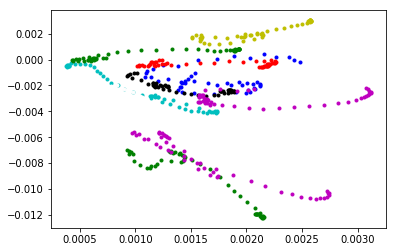

In [30]:
X,Y = KPCAprep(Y_train, 2)

colors = ['g.','b.','y.','r.', 'c.', 'm.', 'k.', 'w.', 'g.', 'm.']


for i in range(10):
    for j in range(len(Y)):
        if (Y[j] == i):
            plt.plot(X[0][j],X[1][j], colors[i])


Just to note there are two purple groups and two green groups, these are seperate and are an artifact of pyplot's coloring system.  It's interesting to see how PCA has compressed the data into these curves.

### 3.g K-means

In [31]:
def euclidDist(X,Y):
    X = np.mat(X)
    Y = np.mat(Y)
    
    cost = np.linalg.norm(X-Y,2)
    cost = cost**2
    
    return cost;

def assignCenters(X,C):
    Z = np.zeros(len(X))
    for i in range(len(X)):
        bestc = -1;
        bestCost = -1;
        for j in range(len(C)):
            tempCost = euclidDist(X[i],C[j])
            if (bestCost == -1):
                bestc = j
                bestCost = tempCost
            else:
                if(tempCost < bestCost):
                    bestc = j
                    bestCost = tempCost
            
        Z[i] = bestc    
           
    return Z       

def calcCenters(X,Z,C):
    # Needs to be re-written for d > 2
    X = np.mat(X)
    
    for i in range(len(C)):
        tempC = [[0.0] * len(X.T)]
        tempC = np.mat(tempC)
        tempCount = 0
        for j in range(len(Z)):
            if (Z[j] == i):
                np.add(tempC, X[j], out=tempC, casting='unsafe')
                #tempC += X[j]
                tempCount += 1
        if (tempCount > 1):        
            tempC = tempC/tempCount
        #print(tempC)
        C[i] = tempC.A.tolist()
    return C

def checkConverge(newC,oldC):
    tol = 10**(-6)
    for i in range(len(newC)):
        temp = abs(euclidDist(newC[i], oldC[i]))
        #print(temp)
        if (temp > tol):
            return False
    
    return True

def checkZConverge(newZ, oldZ):
    for i in range(len(newZ)):
        if (newZ[i] != oldZ[i]):
            return False
    return True

def Kmeans(X,k,seed):
    np.random.seed(seed)
    C = []
    Z = [0] * len(X)
    for i in range(k):
        tempC = math.floor((sp.rand(1) * len(X))[0])
        C.append(X[tempC])
    
    converged = False
    ittr = 0
    
    while(converged == False):
        newZ = assignCenters(X,C)
        
        newC = calcCenters(X,newZ,C)
        
        converged = (checkConverge(newC,C) and checkZConverge(newZ, Z))
            
        Z = newZ
        C = newC      
        ittr += 1
        
        if (ittr > 1000):
            converged = True
    Cluster = []
    for l in range(k):
        tempCluster = []
        for i in range(len(X)):
            if(Z[i] == l):
                tempCluster.append(X[i])
        Cluster.append(tempCluster)       
    
    return [C,Z,k,Cluster]

def KmeanCost(X,Z,C):
    cost = 0
    for i in range(len(X)):
        center = C[int(Z[i])]
        point = X[i]
        cost += euclidDist(point,center)
        
    cost = cost / len(X)
    return cost

def KmeanMain(X,k,r):
    bestrun = 0
    bestCost = 100
    for i in range(r):
        k_val = Kmeans(X,k,i+1)
        C = k_val[0]
        Z = k_val[1]
        k = k_val[2]
        clusters = k_val[3]
        
        cost = KmeanCost(X,Z,C)
        if (cost < bestCost):
            bestCost = cost
            bestrun = i+1
        
    pp.pprint("Min Cost: " +  str(bestCost))
    k_val = Kmeans(X,k,bestrun)
    
        
    return k_val[3]

In [32]:
X,Y = Data_Flattener(Y_train, 340)
clusters = KmeanMain(X, 10,10)

'Min Cost: 5.77178451107'


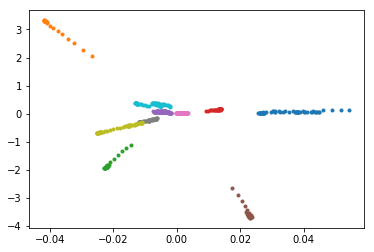

In [36]:
#print(clusters)

for i in range(len(clusters)):
    clusters[i] = KPCA(clusters[i],2)

for i in range(len(clusters)):
    plt.plot(clusters[i][0].T, clusters[i][1].T, '.')

Without further examination of the clusters it does appear that K-means was sucessful in seperating out the different groups.  This is likely due to the fact that the groups are distinctly clumped in their higher dimensional representation.

### 3.g Spectral Clustering

In [37]:
def wij(i,j, ro):
    val = i - j
    val = np.linalg.norm(val, ord=2)
    val = val**2
    val = val / 2*(ro**2)
    val = np.exp(-1 * val)
    #print(val)
    return val
def getkNN(Y,yi, k ):
    temp = []
    for i in range(len(Y)):
        temp.append([euclidDist(Y[i], yi), i])
    
    temp.sort()
    temp = temp[1:(k +1)]
    for i in range(len(temp)):
        temp[i] = temp[i][1:]
    return temp
def buildWMatrix(Y,k, ro):
    W = []
    for i in range(len(Y)):
        temp = []
        knn = getkNN(Y, Y[i], k)
        for j in range(len(Y)):
            if [j] in knn:
                temp.append(wij(Y[i],Y[j], ro))
            else:
                temp.append(0)
        
        W.append(temp)
    
    return W
def buildLaplacian(W):
    D = np.zeros((len(W),len(W)))
    for i in range(len(W)):
        D[i][i] = np.sum(W[i])
        
    L = D-W 
    return L
def spectralCluster(W, Y, k):
    L = buildLaplacian(W)
    Leig = np.linalg.eig(L)
    Lv = Leig[1]
    V = []
    for i in range(k):
        temp = Lv[i].A1.tolist()
        V.append(temp)
    

    V = np.mat(V).T
    clusters = KmeanMain(V.tolist(), k, 10)
    
    newClusters = []
    for i in range(len(clusters)):
        temp = []
        for j in range(len(clusters[i])):
            
            index = V.A.tolist().index(clusters[i][j])
            temp.append(Y.T[index])

        newClusters.append(temp)    
        
        
    return newClusters

K:  15  ro:  0.01


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part


'Min Cost: 0.000383263901657'


IndexError: index 1 is out of bounds for axis 0 with size 1

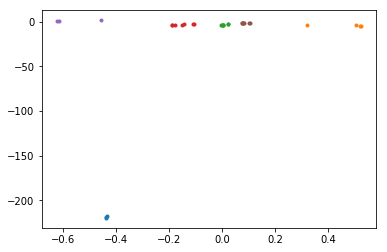

In [47]:
X,Y = Data_Flattener(Y_train, 340)

K = 15
ro = 0.01

print("K: ", K, " ro: ", ro)
W = buildWMatrix(X,K, ro)
W = np.mat(W)

Clusters =spectralCluster(W,X.T, 10)

for i in range(len(Clusters)):
    Clusters[i] = KPCA(Clusters[i],2)

for i in range(len(Clusters)):
    plt.plot(Clusters[i][0].T, Clusters[i][1].T, '.')

my spectral clustering code has always been a bit finicky, so I'm not sure what went wrong here.  The spectral clustering should have been able to seperate the data.